In [1]:
import torch
import numpy as np
import os
import pytorch_lightning as pl

from torchphysics.problem import Variable
from torchphysics.setting import Setting
from torchphysics.problem.domain import Interval
from torchphysics.problem.condition import (DirichletCondition,
                                            DiffEqBoundaryCondition,
                                            DiffEqCondition)
from torchphysics.models.fcn import SimpleFCN
from torchphysics import PINNModule
from torchphysics.utils import grad

from torchphysics.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "" # select GPUs to use

#pl.seed_everything(43) # set a global seed
torch.cuda.is_available()

False

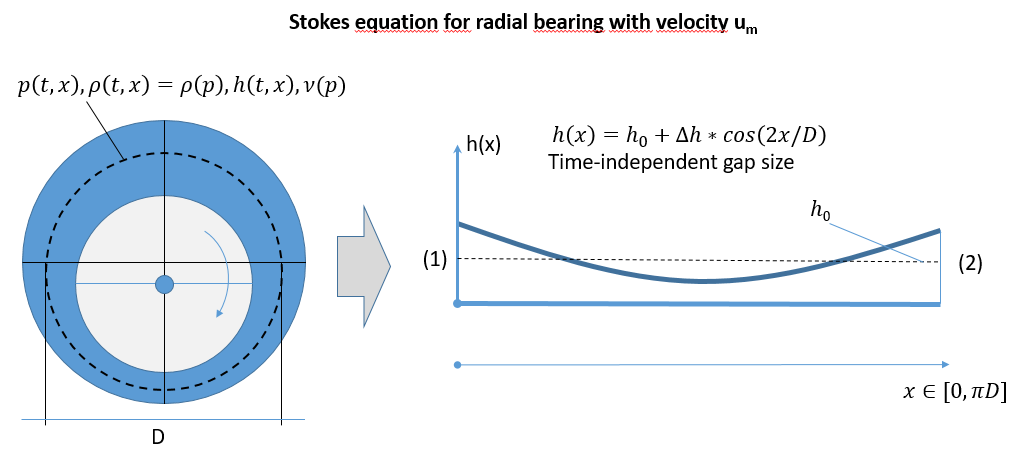

In [2]:
from IPython.display import Image, Math, Latex
from IPython.core.display import HTML 
Image(filename='bearing.png',width = 500, height = 250)

In [3]:
# First define all parameters:
h_0 = 16.e-06 #m = 16 um
dh = 14e-06 #m = 14 um 
D = 0.01 #m = 10 mm 
L = np.pi*D # Länge von Gebiet
u_m = 0.26 #m/s 0.26
beta = 2.2*1e-08 # 2.2e-08 m^2/N
nu_0 = 1.5e-03 # Pa·s = 1.5 mPa·s
# lower and upper bounds of parameters
nu0 = 1.0e-03 # Viskosität
nu1 = 2.5e-03
um0 = 0.2     # Geschwindigkeit
um1 = 0.4
dh0 = 10e-6   # Spaltvariaton
dh1 = 15e-6
p_0 = 1e+5 # 1e+5 N/m^2 = 1 bar
p_rel = 0 # Relativdruck 
p_skal = 100000 #Skalierungsdruck für (-1,1) Bereich

In [4]:
# define h:
def h(x, dh): # <- hier jetzt auch dh als input
    return h_0 + dh * torch.cos(2*x/D) # x in [0,pi*D]                               

# and compute h':
def h_x(x, dh): # <- hier jetzt auch dh als input
    return -2.0*dh/D * torch.sin(2*x/D) # x in [0,pi*D]

In [5]:
# define the function of the viscosity.
# Here we need torch.tensors, since the function will be evaluated in the pde.
# At the beginng the model will have values close to 0, 
# therefore the viscosity will also be close to zero. 
# This will make the pde condition unstable, because we divide by nu.
# For now set values smaller then 1e-06 to 1e-06 
def nu_func(nu, p):
    out = nu * torch.exp(beta * p*p_skal)
    return torch.clamp(out, min=1e-06)

def nu_x_func(nu,p):
    out = nu* beta*p_skal*torch.exp(beta*p*p_skal)
    return out 

In [6]:
# Variables:
x = Variable(name='x', #Ort
             order=1,
             domain=Interval(0, np.pi*D),
             train_conditions={},
             val_conditions={})
nu = Variable(name='nu', # Viskosität
             order=1,
             domain=Interval(low_bound=nu0,
                             up_bound=nu1),
             train_conditions={},
             val_conditions={})
um = Variable(name='um', # Geschwindigkeit
              order=1,
              domain=Interval(low_bound=um0,
                              up_bound=um1),
              train_conditions={},
              val_conditions={})
dh = Variable(name='dh', # Spaltvariation
              order=1,
              domain=Interval(low_bound = dh0,
                              up_bound = dh1),
              train_conditions={},
              val_conditions={})
# Output:
p = 'p'

In [7]:
norm = torch.nn.MSELoss()

# Hier brauchen wir immer nur den output des modells, da die Bedingung nicht
# von nu, um oder dh abhängt.

# Und habe den Rest hier mal weggemacht, da wir den nicht brauchen.
def bcl_fun(p):
    return p-p_rel

def bcr_fun(p):
    return p-p_rel 

# Hier müssen wir jetzt noch die Anzahl der Datenpunkte angegeben
# Vorher war hier: [1,nu_points] = 1 Punkt für x (linker/rechter Rand)
# und verschiedene nu-Punkte.
# Jetzt haben wir vier Variablen, also brauchen wir auch mehr Werte:
nu_points = 20
u_points = 20
dh_points = 20
data_points = [1, nu_points, u_points, dh_points]
# Benutzten werden dann insgesamt immer alle möglichen Kombinationen der erstellten 
# Punkte, womit insgesamt nu_points*u_points*dh_points Punkte verwendet werden.
# Hier also gerade 8000.

# Vielleicht reicht es auch aus sampling_strategy='random' zu setzen, dann werden für nu
# u und dh zufällige Werte verwendet, da diese aber keinen direkten Einfluss auf RB sollte das nicht stören?
# In dem Fall dann z.b. einfach dataset_size = 500, womit dann 500 zufällige Wertekombinationen
# von nu, u und dh gewählt werden. Die x-Werte sind immer fest an dem jeweiligen Rand.
x.add_train_condition(DiffEqBoundaryCondition(bound_condition_fun=bcl_fun,
                                              name='bcl',
                                              norm=norm,
                                              dataset_size = data_points, 
                                              sampling_strategy='grid',
                                              boundary_sampling_strategy='lower_bound_only'))

x.add_train_condition(DiffEqBoundaryCondition(bound_condition_fun=bcr_fun,
                                              name='bcr',
                                              norm=norm,
                                              dataset_size = data_points, 
                                              sampling_strategy='grid',
                                              boundary_sampling_strategy='upper_bound_only'))

In [8]:
display(Math(r'h(x)\frac{d^2 \tilde{p}}{d x^2}  +\left( 3 \frac{dh}{dx} - \frac{h}{\nu} \frac{d \nu}{d x} \right) \frac{d \tilde{p}}{d x} = \frac{6 u_m \nu}{p_0 h^2} \frac{d h}{d x}\quad \mbox{with} \quad \tilde{p}=\frac{p}{p_{skal}} '))

<IPython.core.display.Math object>

In [9]:
def pde(nu, p, x, um, dh): # <- brauchen jetzt dh und um auch als input
    # evaluate the viscosity and their first derivative
    nu = nu_func(nu,p)
    nu_x = nu_x_func(nu,p)
    # implement the PDE:
    # right hand site
    rs = 6*um*nu #<- hier jetzt um statt u_m, da deine Variable so heißt   
    #  h und h_x mit Input dh:
    h_out = h(x, dh) # nur einmal auswerten
    h_x_out = h_x(x, dh) # nur einmal auswerten
    #out = h_out * grad(grad(p,x),x)- rs*h_x_out/h_out/h_out/p_skal
    out = h_out*grad(grad(p,x),x) + (3*h_x_out -h_out/nu*nu_x)*grad(p,x) - rs*h_x_out/h_out/h_out/p_skal
    return out

# Hier ebenfalls vier Variablen, also unsere Werte für das Sampling anpassen. x braucht nun 
# auch eine Anzahl:
x_points = 2000
nu_points = 5
u_points = 5
dh_points = 5
data_points_pde = [x_points, nu_points, u_points, dh_points]
# Hier müsste man überlegen wie man das am besten macht, werden sonst sehr viele Punkte.
# Vielleicht auch hier lieber zufällige Werte, dann:
# sampling_strategy = 'random' und z.b. dataset_size=50000 
train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             norm=norm,
                             weight=1.0,
                             dataset_size=data_points_pde,
                             sampling_strategy = 'grid')


print('pde defined'

In [10]:
setup = Setting(variables=(x, nu, um, dh), # <- hier noch die neuen inputs ergänzen
                train_conditions={'pde': train_cond},
                val_conditions={},
                solution_dims={p: 1},
                n_iterations=20)

In [11]:
solver = PINNModule(model=SimpleFCN(variable_dims=setup.variable_dims,
                                    solution_dims=setup.solution_dims,
                                    normalization_dict=setup.normalization_dict,
                                    depth=3,
                                    width=20),
                    optimizer=torch.optim.Adam,
                    lr=1.e-2)

In [12]:
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=20,
                     log_every_n_steps=1,
                     max_epochs=1,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
C:\Users\inu2sh\Desktop\Torch-Physics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\inu2sh\Desktop\Torch-Physics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing th

Training: -1it [00:00, ?it/s]

In [13]:
# Use LBFGS at the end
solver.lr = 1.e-2
solver.optimizer = torch.optim.LBFGS
solver.optim_params = {'max_iter': 5}
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=20,
                     log_every_n_steps=15,
                     max_epochs=0,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\inu2sh\Desktop\Torch-Physics\_venv\lib\site-packages\pytorch_lightning\core\datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
C:\Users\inu2sh\Desktop\Torch-Physics\_venv\lib\site-packages\pytorch_lightning\core\datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [14]:
from torchphysics.problem.datacreator import InnerDataCreator
from datetime import datetime
datacreator = InnerDataCreator(setup.variables,
                               dataset_size=[200, 10, 10, 10], # Hier wieder die Anzahl der Punkte für die jeweilige Variable
                               sampling_strategy='grid')
data = datacreator.get_data() # Erstellen der Punkte
# Umwandeln in Tensor:
for k in data:
    data[k] = torch.tensor(data[k], device=solver.device)
# Model auswerten
time1 = datetime.now()
out = solver.model(data)
time2 = datetime.now()
time = time2 - time1
print(time)
# max und min bestimmen
max_out = torch.max(out[p]).detach().numpy()
min_out = torch.min(out[p]).detach().numpy()

0:00:00.044071


nu0=  0.001  nu1=  0.0025
dh0=  1e-05 dh1=  1.5e-05 m
um0=  0.2 um1=  0.4 m/s
Minimale Spalthöhe = 1.4999999999999992e-06
Skalierungsfaktor =  100000


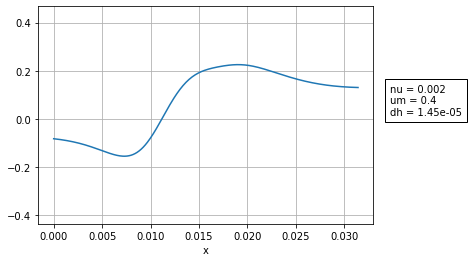

In [15]:
from torchphysics.utils.plot import _plot
import matplotlib.pyplot as plt
solver = solver.to('cpu')
print('nu0= ',nu0,' nu1= ',nu1)
print('dh0= ',dh0, 'dh1= ', dh1, 'm')
print('um0= ', um0, 'um1= ',um1, 'm/s')
# Parameter definieren für Plot
nu = 2.0e-3 
um = 0.4
dh = 14.5e-06
print('Minimale Spalthöhe =',  h_0-dh)
if nu0<=nu and nu<=nu1 and dh0<=dh and dh<=dh1 and um0<=um and um<=um1:
    fig = _plot(model=solver.model, solution_name='p', plot_variables=[x],
                points=300, angle=[30, 30], dic_for_other_variables={'nu': nu, 'um': um, 'dh': dh})
    fig.get_axes()[0].set_ylim([min_out, max_out])
else:
    print('Ausserhalb des Trainingsbereiches')
print('Skalierungsfaktor = ', p_skal)
plt.savefig(f'p_{um}.png', dpi=300)

In [18]:
import xlsxwriter
#erstellen eines Workbook Objektes mit dem Dateinamen "Gleitlager_***.xlsx"
workbook = xlsxwriter.Workbook('Gleitlager.xlsx')
worksheet = workbook.add_worksheet('Tabelle_1')

worksheet.write('Ergebnistabelle Gleitlager')
worksheet.write('nu', 'dh', 'um')

workbook.close()

AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)